In [1]:
using AutoRisk
using BayesNets
using DataFrames
using Discretizers
using Distributions
using HDF5
using Interact
using JLD
using PGFPlots
using TikzPictures

In [38]:
# load the data
input_filepath = "../../data/datasets/april/risk_mc_32.h5"
raw_features = h5open(input_filepath, "r") do file
    read(file, "risk/features")
end;
raw_targets = h5open(input_filepath, "r") do file
    read(file, "risk/targets")
end;

In [39]:
debug_size = min(1000000, size(raw_features, 3))
timestep = size(raw_features, 2)
features = view(raw_features, :, timestep, 1:debug_size);
targets = view(raw_targets, :, 1:debug_size);

In [40]:
# sanitize the data
# remove features deterministically associated with a collision
valid_target_inds = find(abs(sum(targets[1:3,:], 1) .- 1.) .> 1e-2)

# clip velocities
vel_ind = find(feature_names .== "velocity")[1]
valid_vel_inds = find(0. .< features[vel_ind, :] .< 30.)

# clip distances
dist_ind = find(feature_names .== "fore_m_dist")[1]
valid_dist_inds = find(0. .< features[dist_ind, :] .< 100.)

valid_inds = intersect(valid_target_inds, valid_vel_inds, valid_dist_inds)
features = features[:, valid_inds];
println(size(valid_inds))
println(size(features))

(97661,)
(236,97661)


In [41]:
attributes = h5readattr(input_filepath, "risk")
feature_names = attributes["feature_names"];

In [42]:
bn_feature_names = ["velocity", "fore_m_vel", "fore_m_dist"]
inds = [find(feature_names .== name)[1] for name in bn_feature_names]
base_data = features[inds,:];

In [43]:
# add aggressivenss by inferring it from politeness
politeness_index = find(feature_names .== "lane_politeness")[1]
politness_values = features[politeness_index,:];
aggressiveness_values = infer_correlated_aggressiveness(politness_values);
aggressiveness_values = reshape(aggressiveness_values, (1, length(aggressiveness_values)))
push!(bn_feature_names, "aggressiveness")
data = cat(1, base_data, aggressiveness_values)

4×97661 Array{Float64,2}:
 13.2999    12.8406    12.9018    …  12.7906     8.09966   11.8548  
 13.1439    13.5248    13.4087       14.1701    10.2777    14.1283  
 19.6273    16.9058    17.8109       28.0427    18.0231    25.7348  
  0.236033   0.346517   0.312707      0.128492   0.932136   0.998684

In [44]:
# get is_attentive separately since it's discrete
is_attentive_index = find(feature_names .== "is_attentive")[1]
num_samples = size(data, 2)
is_attentive_values = ones(Int, num_samples)
for sidx in 1:num_samples
    is_attentive_values[sidx] = features[is_attentive_index,sidx] > .5 ? 2 : 1
end

In [45]:
# discretize the data
# features
num_variables, num_samples = size(data)
num_bins = [5,5,10,4]
disc_data = zeros(Int, num_variables, num_samples)
cutpoints = []
discs = []
for vidx in 1:num_variables
    disc = LinearDiscretizer(binedges(DiscretizeUniformCount(num_bins[vidx]), data[vidx,:]))
    push!(cutpoints, disc.binedges)
    for sidx in 1:num_samples
        c = 0
        val = data[vidx, sidx]
        for (c, (lo, hi)) in enumerate(zip(disc.binedges, disc.binedges[2:end]))
            if lo <= val < hi
                break
            end
        end
    disc_data[vidx, sidx] = c
    end
end
println(cutpoints)

Any[[0.0103657,12.1535,13.7303,15.057,16.7117,24.9619],[-5.9304,12.1803,13.7697,15.1134,16.8198,26.9756],[0.716041,15.7165,18.6641,21.06,23.2934,25.7032,28.61,32.6929,39.521,53.0271,99.9875],[7.82976e-6,0.254671,0.503513,0.751626,0.999999]]


In [46]:
# convert data to dataframe
training_data = DataFrame(
        velocity = disc_data[1,:], 
        forevelocity = disc_data[2,:],
        foredistance = disc_data[3,:], 
        aggressiveness = disc_data[4,:],
        isattentive = is_attentive_values
);

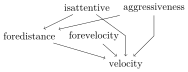

In [47]:
bn = fit(DiscreteBayesNet, training_data, (
    :isattentive=>:foredistance, 
    :isattentive=>:velocity,
    :aggressiveness=>:foredistance, 
    :aggressiveness=>:velocity,
    :foredistance=>:velocity,
    :forevelocity=>:velocity
    )
)

In [48]:
# report CPDs
for k in [:isattentive, :aggressiveness, :foredistance, :forevelocity, :velocity]
    println(table(bn, k))
end

2×2 DataFrames.DataFrame
│ Row │ isattentive │ p         │
├─────┼─────────────┼───────────┤
│ 1   │ 1           │ 0.0258343 │
│ 2   │ 2           │ 0.974166  │
4×2 DataFrames.DataFrame
│ Row │ aggressiveness │ p        │
├─────┼────────────────┼──────────┤
│ 1   │ 1              │ 0.250008 │
│ 2   │ 2              │ 0.249997 │
│ 3   │ 3              │ 0.249997 │
│ 4   │ 4              │ 0.249997 │
80×4 DataFrames.DataFrame
│ Row │ aggressiveness │ isattentive │ foredistance │ p         │
├─────┼────────────────┼─────────────┼──────────────┼───────────┤
│ 1   │ 1              │ 1           │ 1            │ 0.174242  │
│ 2   │ 2              │ 1           │ 1            │ 0.122383  │
│ 3   │ 3              │ 1           │ 1            │ 0.036566  │
│ 4   │ 4              │ 1           │ 1            │ 0.0130506 │
│ 5   │ 1              │ 2           │ 1            │ 0.196582  │
│ 6   │ 2              │ 2           │ 1            │ 0.142851  │
│ 7   │ 3              │ 2           │ 1    

In [49]:
# map the feature symbols to binedges
var_edges = Dict{Symbol,Vector{Float64}}()
var_edges[:velocity] = cutpoints[1]
var_edges[:forevelocity] = cutpoints[2]
var_edges[:foredistance] = cutpoints[3]
var_edges[:aggressiveness] = cutpoints[4]
var_edges

Dict{Symbol,Array{Float64,1}} with 4 entries:
  :velocity       => [0.0103657,12.1535,13.7303,15.057,16.7117,24.9619]
  :foredistance   => [0.716041,15.7165,18.6641,21.06,23.2934,25.7032,28.61,32.6…
  :forevelocity   => [-5.9304,12.1803,13.7697,15.1134,16.8198,26.9756]
  :aggressiveness => [7.82976e-6,0.254671,0.503513,0.751626,0.999999]

In [50]:
JLD.save("../../data/bayesnets/base_test.jld", "bn", bn, "var_edges", var_edges)

In [54]:
# proposal bn
is_attentive_values[:] = 1
is_attentive_values[1] = 2
disc_data[3,:] = 1
training_data = DataFrame(
        velocity = disc_data[1,:], 
        forevelocity = disc_data[2,:],
        foredistance = disc_data[3,:], 
        aggressiveness = disc_data[4,:],
        isattentive = is_attentive_values
);

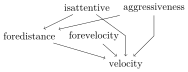

In [55]:
bn = fit(DiscreteBayesNet, training_data, (
    :isattentive=>:foredistance, 
    :isattentive=>:velocity,
    :aggressiveness=>:foredistance, 
    :aggressiveness=>:velocity,
    :foredistance=>:velocity,
    :forevelocity=>:velocity
    )
)

In [56]:
JLD.save("../../data/bayesnets/prop_test.jld", "bn", bn, "var_edges", var_edges)